# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. Because this tutorial uses 3D feature detection, you must use the v1.5 (3D and PBC changes) of *tobac*. 


This tutorial requires the use of pre-gridded radar data, which we generated during the Py-ART tutorial.

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pyart
import glob
import datetime
import matplotlib.gridspec as gridspec
import pandas as pd
import os
import math
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### DATA INPUT:
https://tobac.readthedocs.io/en/latest/data_input.html

We use the gridded data from the Py-ART tutorial.

In [13]:
gridded_files = sorted(glob.glob("../../data/uah-armor/gridded/*.nc"))

In [54]:
ds = xr.open_mfdataset(gridded_files).squeeze()
ds

<xarray.Dataset>
Dimensions:       (time: 25, z: 30, y: 600, x: 600)
Coordinates:
  * time          (time) datetime64[ns] 2008-04-11T18:12:23 ... 2008-04-11T20...
  * z             (z) float64 0.0 517.2 1.034e+03 ... 1.448e+04 1.5e+04
    lat           (y, x) float64 dask.array<chunksize=(600, 600), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(600, 600), meta=np.ndarray>
  * y             (y) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
  * x             (x) float64 -1.5e+05 -1.495e+05 ... 1.495e+05 1.5e+05
Data variables:
    reflectivity  (time, z, y, x) float32 dask.array<chunksize=(1, 30, 600, 600), meta=np.ndarray>
    ROI           (time, z, y, x) float32 dask.array<chunksize=(1, 30, 600, 600), meta=np.ndarray>

##### *tobac* is designed to work with **gridded** data currently, so using pre-gridded data, or data we must first grid the radial radar data. This is a quick and dirty gridding, but it will get the job done for this tutorial. Much better gridding results could be had with tuning of the parameters. 


#### Let's Look at the data - there's a number of ways to do a quick look, we're going to use pcolormesh. We can look at a specific level of the data, or create a composite reflectivity. Let's do both!

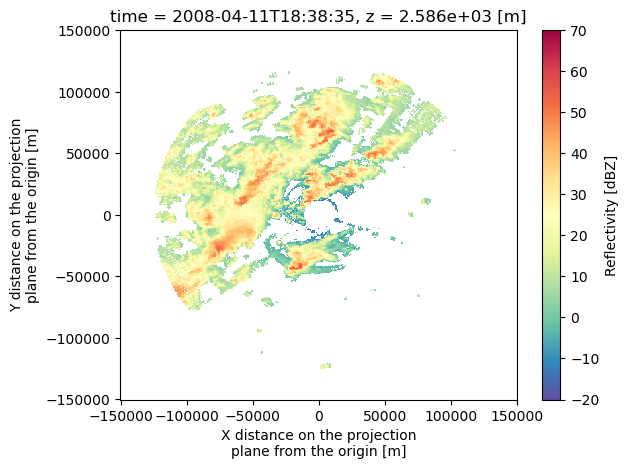

In [21]:
#Looking at a specific level and time of our data
ds.reflectivity.isel(time=5, z=5).plot(cmap='Spectral_r', vmin=-20, vmax=70)

In [22]:
#QUICK COMPOSITE REFLECTIVITY HERE:
maxrefl = ds['reflectivity'].max(dim='z')

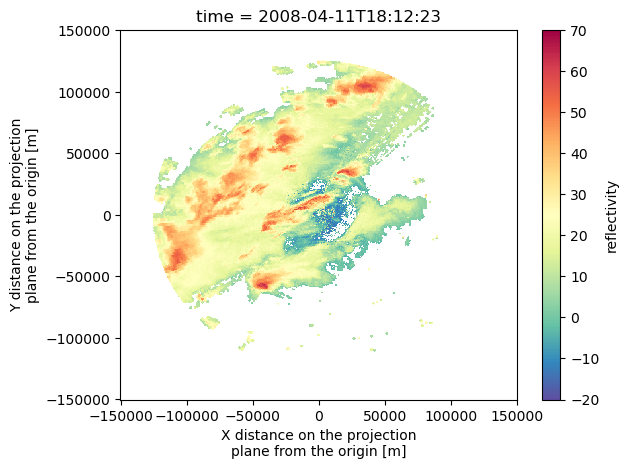

In [26]:
maxrefl.isel(time=0).plot(cmap='Spectral_r', vmin=-20, vmax=70)

Load in *tobac*

In [27]:
import tobac
import tobac.testing
import tobac.feature_detection
import tobac.segmentation

In [55]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30]#, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


Note that to track in 3D, we must give information about what our height coordinate is. Iris tends to be picky about the naming conventions, so we need to assign standard names as well.

In [63]:
ds.z.attrs["standard_name"] = "altitude"
ds.lat.attrs["standard_name"] = "latitude"
ds.lon.attrs["standard_name"] = "longitude"

xr_grid_full = ds["reflectivity"]

In [64]:
#Even though we read in our data using Xarray, and Xarray is our data handler of choice (could also be Pandas)
#we need to conver this data to iris cubes. Future versions of tobac will be built on Xarray, but for now we convert.
grid_iris = xr_grid_full.to_iris()


In [ ]:
# #FURTHER, to use tobac we need to know the grid spacing in both x/y/z and time:
# # #Dt, DXY
# datetimes = xr_grid_full['time']
# timedeltas = [(datetimes[i-1]-datetimes[i]).astype('timedelta64[m]') for i in range(1, len(datetimes))]
# print(len(timedeltas))
# average_timedelta = sum(timedeltas) / len(timedeltas)
# dt = np.abs(np.array(average_timedelta)).astype('timedelta64[m]').astype(int)


# deltax = [xr_grid_full['x'][i-1]-xr_grid_full['x'][i] for i in range(1, len(xr_grid_full['x']))]
# dxy = np.abs(np.mean(deltax).astype(int))/1000


# print(dxy,dt)

In [65]:
dxy, dt = tobac.utils.get_spacings(grid_iris)
print(dxy)
print(dt)

500.8347245409095
300


In [66]:
#I also want to define a save directory. 
#Set up directory to save output and plots:
savedir='tobac_Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir=savedir+"/tobac_Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## We're going to start simple before getting more complicated: tracking in 2D

In [67]:
#Create a composite reflectivity to get started, turning our 3D reflectivity into 2D:
maxrefl = xr_grid_full.max(dim='z')

In [68]:
#Convert to iris:
maxrefl_iris = maxrefl.to_iris()

In [69]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(maxrefl_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('features saved')

starting feature detection based on multiple thresholds
feature detection done
features saved


In [70]:
Features

<xarray.Dataset>
Dimensions:                  (index: 1014)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1010 1011 1012 1013
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 24 24 24 24 24 24
    idx                      (index) int64 1 2 3 4 6 7 8 ... 65 66 67 68 69 71
    hdim_1                   (index) float64 190.9 305.6 232.7 ... 467.1 536.8
    hdim_2                   (index) float64 217.4 132.7 187.5 ... 428.8 359.8
    num                      (index) int64 1079 9688 75 5 7 ... 223 12 15 37 7
    threshold_value          (index) int64 30 30 30 30 30 30 ... 30 30 30 30 30
    ...                       ...
    time                     (index) object 2008-04-11 18:12:23 ... 2008-04-1...
    timestr                  (index) object '2008-04-11 18:12:23' ... '2008-0...
    projection_y_coordinate  (index) float64 -5.438e+04 3.059e+03 ... 1.188e+05
    projection_x_coordinate  (index) float64 -4.111e+04 -8.352e+04 ... 3.019e+04
    latitude                 (index) float64 34.16 34.67 34.34 ... 35.4 35.71
    longitude                (index) float64 -87.22 -87.68 ... -86.06 -86.44

In [71]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 30 
#parameters_segmentation['features']
#parameters_segmentation['field']
#parameters_segmentation['dxy']
#parameters_segmentation['target']
#parameters_segmentation['level']
#parameters_segmentation['max_distance']
#Maximum distance from a marker allowed to be classified as
        #belonging to that cell. Default is None.
#parameters_segmentation['vertical_coord']

In [72]:
# Features_df=Features.to_dataframe()

# Perform Segmentation and save resulting mask to NetCDF file:
print('Starting segmentation based on reflectivity')
Mask_iris,Features_Precip =tobac.segmentation.segmentation(Features_df,maxrefl_iris,dxy,**parameters_segmentation)

Mask=xr.DataArray.from_iris(Mask_iris)
Mask = Mask.to_dataset()


#Mask,Features_Precip=segmentation(Features,maxrefl,dxy,**parameters_segmentation)
print('segmentation based on reflectivity performed, start saving results to files')
Mask.to_netcdf(os.path.join(savedir,'Mask_Segmentation_refl.nc'))                


Starting segmentation based on reflectivity
segmentation based on reflectivity performed, start saving results to files


In [73]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3 #5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 
parameters_linking['memory']= 3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=0.6 
parameters_linking['d_min']= None #5 


In [74]:
# Perform trajectory linking using trackpy and save the resulting DataFrame:

Track_df=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)

Track = Track_df.to_xarray()

Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 24: 56 trajectories present.


/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/trackpy/predict.py:227: UserWarning: Could not generate velocity field for prediction: no tracks
  warn('Could not generate velocity field for prediction: no tracks')
/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


In [78]:
Features

<xarray.Dataset>
Dimensions:                  (index: 1014)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1010 1011 1012 1013
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 24 24 24 24 24 24
    idx                      (index) int64 1 2 3 4 6 7 8 ... 65 66 67 68 69 71
    hdim_1                   (index) float64 190.9 305.6 232.7 ... 467.1 536.8
    hdim_2                   (index) float64 217.4 132.7 187.5 ... 428.8 359.8
    num                      (index) int64 1079 9688 75 5 7 ... 223 12 15 37 7
    threshold_value          (index) int64 30 30 30 30 30 30 ... 30 30 30 30 30
    ...                       ...
    time                     (index) object 2008-04-11 18:12:23 ... 2008-04-1...
    timestr                  (index) object '2008-04-11 18:12:23' ... '2008-0...
    projection_y_coordinate  (index) float64 -5.438e+04 3.059e+03 ... 1.188e+05
    projection_x_coordinate  (index) float64 -4.111e+04 -8.352e+04 ... 3.019e+04
    latitude                 (index) float64 34.16 34.67 34.34 ... 35.4 35.71
    longitude                (index) float64 -87.22 -87.68 ... -86.06 -86.44

In [75]:
d = tobac.merge_split.merge_split_MEST(Track_df,500., distance=25000.0)

Track = xr.open_dataset(savedir+"/Track.nc")
# ds = tobac.utils.standardize_track_dataset(Track, refl_mask)#, data['ProjectionCoordinateSystem'])
# both_ds = xarray.merge([ds, d],compat ='override')

# both_ds = tobac.utils.compress_all(both_ds)
# both_ds.to_netcdf(os.path.join(savedir,'Track_features_merges.nc'))

In [79]:
d

<xarray.Dataset>
Dimensions:                   (track: 1, cell: 1, feature: 1014)
Coordinates:
  * track                     (track) float64 0.0
  * cell                      (cell) int64 -1
  * feature                   (feature) int64 1 2 3 4 5 ... 1011 1012 1013 1014
Data variables:
    cell_parent_track_id      (cell) float64 0.0
    feature_parent_cell_id    (feature) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
    feature_parent_track_id   (feature) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0
    track_child_cell_count    (track) float64 1.0
    cell_child_feature_count  (cell) float64 1.014e+03

In [80]:

Track = xr.open_dataset(savedir+"/Track.nc")
Features = xr.open_dataset(savedir+"/Features.nc")
refl_mask = xr.open_dataset(savedir+"/Mask_Segmentation_refl.nc")

# both_ds = xarray.open_dataset(savedir+'/Track_features_merges.nc')

In [81]:
Features

<xarray.Dataset>
Dimensions:                  (index: 1014)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1010 1011 1012 1013
Data variables: (12/13)
    frame                    (index) int64 ...
    idx                      (index) int64 ...
    hdim_1                   (index) float64 ...
    hdim_2                   (index) float64 ...
    num                      (index) int64 ...
    threshold_value          (index) int64 ...
    ...                       ...
    time                     (index) datetime64[ns] ...
    timestr                  (index) object ...
    projection_y_coordinate  (index) float64 ...
    projection_x_coordinate  (index) float64 ...
    latitude                 (index) float64 ...
    longitude                (index) float64 ...

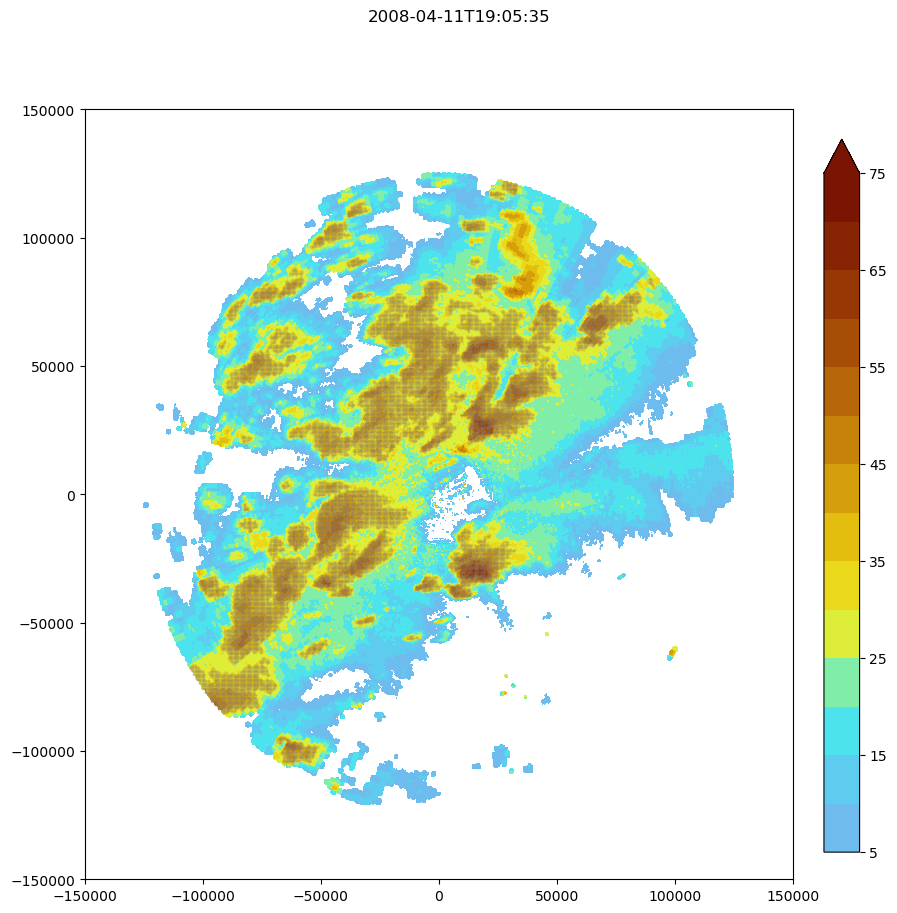

In [82]:
#
frame = 10
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    


for i in Track['cell']:
    if i < 0:
        continue
    #print(i)
    if math.isfinite(i):
        cell_i = np.where(d['feature_parent_cell_id'] == i)
        if (np.nanmax(Features['frame'][cell_i]) >= frame) and (np.nanmin(Features['frame'][cell_i]) <= frame):
            ax.plot(Track['projection_x_coordinate'][cell_i], Track['projection_y_coordinate'][cell_i], '-.',color='r')
            ax.text(Track['projection_x_coordinate'][cell_i][-1],Track['projection_y_coordinate'][cell_i][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue
 





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')




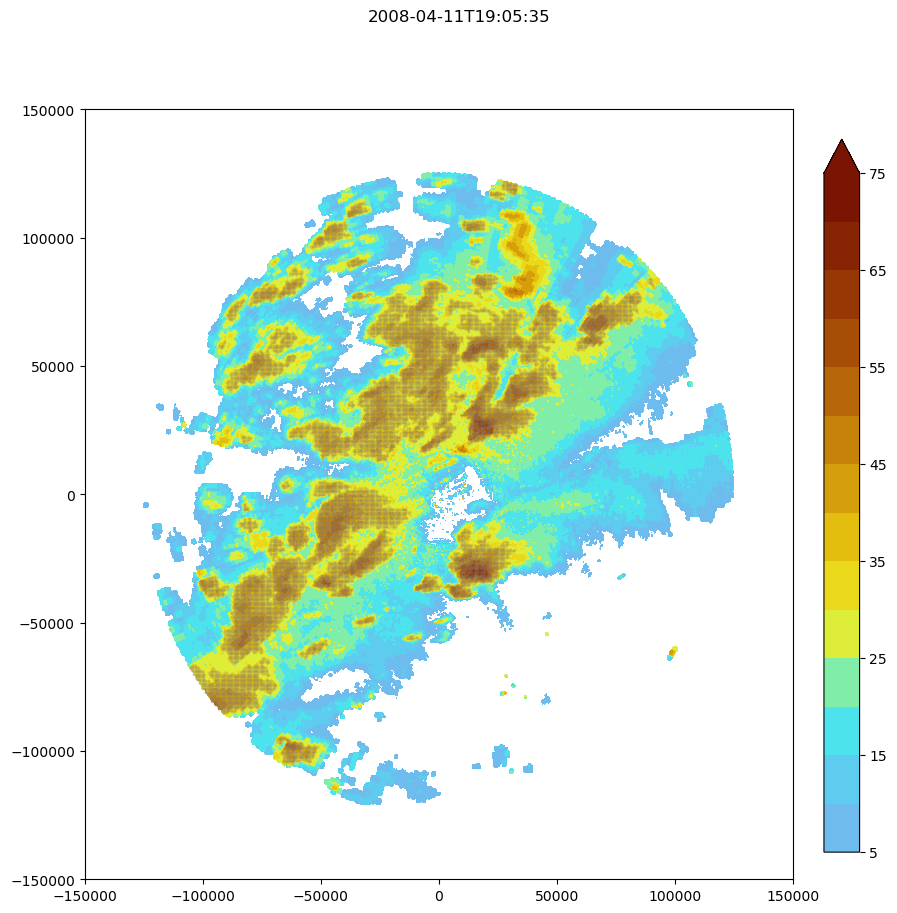

In [83]:
#
frame = 10
isolated_min = 0.5
show_tracks = True
ref_levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

fig, ax = plt.subplots(figsize=(10,10))

refl = maxrefl[frame,:,:] 
fig.suptitle(str(maxrefl['time'][frame].data)[:-10])
y_mesh,x_mesh = np.meshgrid(maxrefl['x'],maxrefl['y'])
    
refplt = ax.contourf(y_mesh,x_mesh, refl, extend = 'max',levels = ref_levels,cmap='pyart_LangRainbow12',origin = 'lower', vmin=-24, vmax=72)#,extent = [0,-10000,-20000,-10000])
fig.colorbar(refplt,fraction=0.046, pad=0.04)
i = np.where(Mask['segmentation_mask'][frame,:,:] > 0)
    

y, x = y_mesh[i[0],i[1]],x_mesh[i[0],i[1]]
imcell2 = ax.scatter(y,x,s = 0.1,c = 'gray', marker = '.',alpha = 0.75)
    



for i in d['track']:
    track_i = np.where(d['cell_parent_track_id'] == i.values)
    for cell in d['cell'][track_i]:
        if cell < 0:
            continue

        feature_id = np.where(d['feature_parent_cell_id'] == cell)
        if (frame <= np.nanmax(Features['frame'][feature_id])) and (frame >= np.nanmin(Features['frame'][feature_id])):
            ax.plot(Track['projection_x_coordinate'][feature_id], Track['projection_y_coordinate'][feature_id], '-.',color='b',alpha = 0.5)
            ax.text(Track['projection_x_coordinate'][feature_id][-1],Track['projection_y_coordinate'][feature_id][-1], f'{int(i)}', fontsize = 'small',rotation = 'vertical')
        else:
            continue





#     fig.savefig(plot_dir+'/'+'20260331_track_'+str(frame)+'.png')




# Multiple Thresholds

In [84]:
feature_detection_params['threshold'] = [30, 40, 50]

In [85]:
xr_grid_full

<xarray.DataArray 'reflectivity' (time: 25, z: 30, y: 600, x: 600)>
dask.array<concatenate, shape=(25, 30, 600, 600), dtype=float32, chunksize=(1, 30, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2008-04-11T18:12:23 ... 2008-04-11T20:20:58
  * z        (z) float64 0.0 517.2 1.034e+03 ... 1.397e+04 1.448e+04 1.5e+04
    lat      (y, x) float64 dask.array<chunksize=(600, 600), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(600, 600), meta=np.ndarray>
  * y        (y) float64 -1.5e+05 -1.495e+05 -1.49e+05 ... 1.495e+05 1.5e+05
  * x        (x) float64 -1.5e+05 -1.495e+05 -1.49e+05 ... 1.495e+05 1.5e+05
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    coordinates:    elevation azimuth range

In [86]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(maxrefl_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

# Features.to_netcdf(os.path.join(savedir,'Features.nc'))
# print('features saved')

starting feature detection based on multiple thresholds
feature detection done


In [87]:
Features_df

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,0,3,232.654355,187.475227,75,30,1,2008-04-11 18:12:23,2008-04-11 18:12:23,-33478.620116,-56105.896173,34.343593,-87.382608
1,0,4,256.679129,59.120160,5,30,2,2008-04-11 18:12:23,2008-04-11 18:12:23,-21446.178957,-120390.570710,34.446289,-88.084443
2,0,6,271.000000,227.817852,7,30,3,2008-04-11 18:12:23,2008-04-11 18:12:23,-14273.789649,-35900.909033,34.517206,-87.163348
3,0,8,291.189565,62.745582,5,30,4,2008-04-11 18:12:23,2008-04-11 18:12:23,-4162.154494,-118574.833957,34.601917,-88.067061
4,0,9,324.167350,103.064594,111,30,5,2008-04-11 18:12:23,2008-04-11 18:12:23,12354.265509,-98381.672359,34.752573,-87.848376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,24,121,181.281622,275.366252,88,50,1495,2008-04-11 20:20:58,2008-04-11 20:20:58,-59207.868610,-12087.018954,34.113660,-86.902791
1495,24,122,197.820473,325.438786,10,50,1496,2008-04-11 20:20:58,2008-04-11 20:20:58,-50924.637719,12991.044798,34.188142,-86.630264
1496,24,124,306.319990,384.751210,88,50,1497,2008-04-11 20:20:58,2008-04-11 20:20:58,3415.687706,42696.766189,34.676028,-86.304585
1497,24,125,303.064874,488.028903,71,50,1498,2008-04-11 20:20:58,2008-04-11 20:20:58,1785.412871,94421.821376,34.657907,-85.739151


In [88]:
Features

<xarray.Dataset>
Dimensions:                  (index: 1499)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1495 1496 1497 1498
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 24 24 24 24 24 24
    idx                      (index) int64 3 4 6 8 9 12 ... 121 122 124 125 126
    hdim_1                   (index) float64 232.7 256.7 271.0 ... 303.1 333.3
    hdim_2                   (index) float64 187.5 59.12 227.8 ... 488.0 386.0
    num                      (index) int64 75 5 7 5 111 17 ... 30 88 10 88 71 21
    threshold_value          (index) int64 30 30 30 30 30 30 ... 50 50 50 50 50
    ...                       ...
    time                     (index) object 2008-04-11 18:12:23 ... 2008-04-1...
    timestr                  (index) object '2008-04-11 18:12:23' ... '2008-0...
    projection_y_coordinate  (index) float64 -3.348e+04 -2.145e+04 ... 1.695e+04
    projection_x_coordinate  (index) float64 -5.611e+04 -1.204e+05 ... 4.331e+04
    latitude                 (index) float64 34.34 34.45 34.52 ... 34.66 34.8
    longitude                (index) float64 -87.38 -88.08 ... -85.74 -86.3

In [89]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['stubs'] = 3 #5
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=2 #Order of polynomial for extrapolating
parameters_linking['subnetwork_size']=100 
parameters_linking['memory']= 3#4
#parameters_linking['time_cell_min']=1
parameters_linking['v_max']=30
parameters_linking['d_min']= None #5 

# Track_df=tobac.linking_trackpy(Features_df,Mask_iris,dt=dt,dxy=dxy,**parameters_linking)

In [90]:
multiple_tracking = tobac.linking_trackpy(Features_df, None, dt=dt,dxy=dxy,**parameters_linking)

Frame 24: 75 trajectories present.


In [91]:
multiple_tracking

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,3,232.654355,187.475227,75,30,1,2008-04-11 18:12:23,2008-04-11 18:12:23,-33478.620116,-56105.896173,34.343593,-87.382608,1,0 days 00:00:00
1,0,4,256.679129,59.120160,5,30,2,2008-04-11 18:12:23,2008-04-11 18:12:23,-21446.178957,-120390.570710,34.446289,-88.084443,-1,NaT
2,0,6,271.000000,227.817852,7,30,3,2008-04-11 18:12:23,2008-04-11 18:12:23,-14273.789649,-35900.909033,34.517206,-87.163348,-1,NaT
3,0,8,291.189565,62.745582,5,30,4,2008-04-11 18:12:23,2008-04-11 18:12:23,-4162.154494,-118574.833957,34.601917,-88.067061,-1,NaT
4,0,9,324.167350,103.064594,111,30,5,2008-04-11 18:12:23,2008-04-11 18:12:23,12354.265509,-98381.672359,34.752573,-87.848376,-1,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,24,121,181.281622,275.366252,88,50,1495,2008-04-11 20:20:58,2008-04-11 20:20:58,-59207.868610,-12087.018954,34.113660,-86.902791,-1,NaT
1495,24,122,197.820473,325.438786,10,50,1496,2008-04-11 20:20:58,2008-04-11 20:20:58,-50924.637719,12991.044798,34.188142,-86.630264,247,0 days 00:33:48
1496,24,124,306.319990,384.751210,88,50,1497,2008-04-11 20:20:58,2008-04-11 20:20:58,3415.687706,42696.766189,34.676028,-86.304585,158,0 days 01:15:23
1497,24,125,303.064874,488.028903,71,50,1498,2008-04-11 20:20:58,2008-04-11 20:20:58,1785.412871,94421.821376,34.657907,-85.739151,23,0 days 02:08:35


# 3d Tracking

#### Notice that the field we're tracking on has switched from the 2d composite reflectivity field to the 3D reflectivity field (still in an iris cube). 

In [92]:
#FIND OUR FEATURES!

print('starting feature detection based on multiple thresholds')
Features_df = tobac.feature_detection_multithreshold(grid_iris, dxy, **feature_detection_params)

Features=Features_df.to_xarray()
print('feature detection done')

# Features.to_netcdf(os.path.join(savedir,'Features.nc'))
# print('features saved')

starting feature detection based on multiple thresholds
feature detection done


In [93]:
multiple_tracking = tobac.linking_trackpy(Features_df, None, dt=dt,dxy=dxy,**parameters_linking)

Frame 21: 1 trajectories present.


/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/trackpy/predict.py:227: UserWarning: Could not generate velocity field for prediction: no tracks
  warn('Could not generate velocity field for prediction: no tracks')
